# Steady State Auditory Evoked Potential

In this experiment, participants were presented with sounds of two different amplitude modulation frequencies.

Stimuli were presented for 3 s with an intertrial interval of 600 ms and random jitter of ±100ms. The task was to passively fixate the center of the screen while the stimuli were played. Six blocks of 2 min were recorded for a single partipant.

The stimuli were amplitude-modulated sine waves with carrier frequencies of 900 and 770 Hz, and amplitude modulation frequencies of 45 and 40 Hz, respectively.

In [1]:
import os
import sys
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('../muse')
import utils

## Load data into MNE objects

In [2]:
subject = 1
session = 1
raw = utils.load_data('auditory/SSAEP', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3], 
                      replace_ch_names={'Right AUX': 'POz'})

stim_freqs = [45, 40]
stim_freqs_str = ['{} Hz'.format(f) for f in stim_freqs]

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.


## Visualizing in the frequency domain

We epoch the raw data according to the conditions, and visualize the spectrum of each condition. We expect clear peaks in the spectral domain at the stimulation frequencies of 45 and 40 Hz.

In [3]:
from mne import Epochs, find_events

events = find_events(raw)
event_id = {stim_freqs_str[0]: 1, stim_freqs_str[1]: 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3])

197 events found
Events id: [1 2]


Effective window size : 4.016 (s)
Effective window size : 4.016 (s)


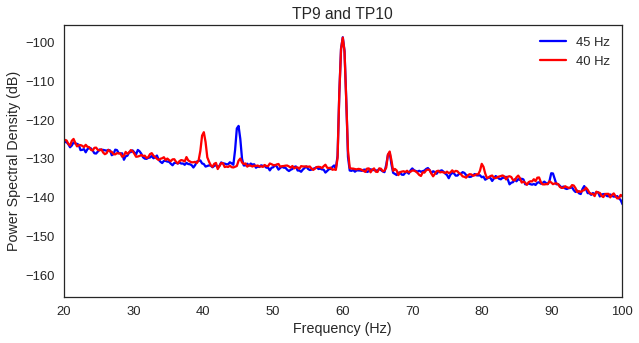

In [4]:
from mne.time_frequency import psd_welch

f, ax = plt.subplots(figsize=(10, 5))
psd1, freq1 = psd_welch(epochs[stim_freqs_str[0]], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs[stim_freqs_str[1]], n_fft=1028, n_per_seg=256 * 3)
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)

psd2_mean = psd2.mean(0)
psd2_std = psd2.mean(0)

ax.plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label=stim_freqs_str[0])
ax.plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label=stim_freqs_str[1])

ax.set_title('TP9 and TP10')
ax.set_ylabel('Power Spectral Density (dB)')
ax.set_xlim((20, 100))
ax.set_xlabel('Frequency (Hz)')
ax.legend()

plt.show()

We can see the expected peaks - along with their first harmonic - in the temporo-parietal electrodes (the peaks at 60 and 68 Hz are noise).

This can also be seen using a time-frequency plot:

Applying baseline correction (mode: logratio)


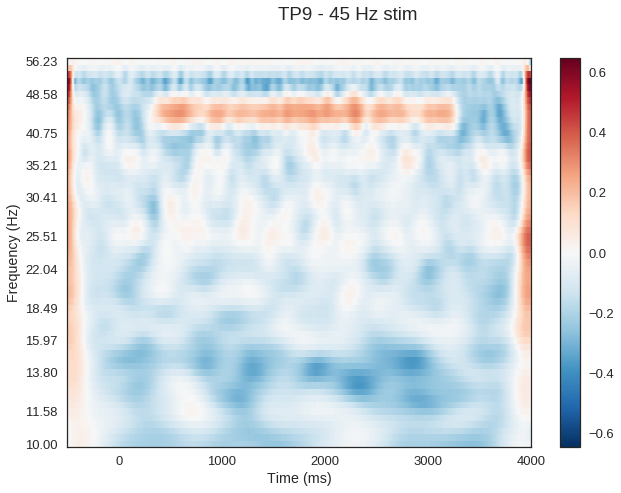

Applying baseline correction (mode: logratio)


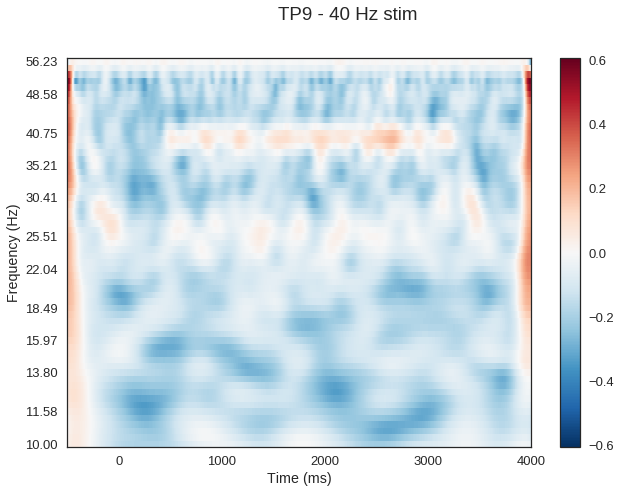

In [5]:
from mne.time_frequency import tfr_morlet

frequencies = np.logspace(1, 1.75, 60)
tfr, itc = tfr_morlet(epochs[stim_freqs_str[0]], freqs=frequencies, 
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[0], baseline=(-0.5, -0.1), mode='logratio', 
         title='TP9 - {} stim'.format(stim_freqs_str[0]));

tfr, itc = tfr_morlet(epochs[stim_freqs_str[1]], freqs=frequencies, 
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[0], baseline=(-0.5, -0.1), mode='logratio', 
         title='TP9 - {} stim'.format(stim_freqs_str[1]));

## Filtering

We filter data between 30 and 55 Hz.

In [6]:
raw_filt = raw.copy().filter(3, 48, method='iir')

Setting up band-pass filter from 3 - 48 Hz


## Epoching

Here we epoch data for -100 ms to 3 s after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs were the signal exceeds 100 uV.

In [7]:
events = find_events(raw)
event_id = {stim_freqs_str[0]: 1, stim_freqs_str[1]: 2}

epochs = Epochs(raw_filt, events=events, event_id=event_id, 
                tmin=-1, tmax=3, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3])

197 events found
Events id: [1 2]


## Epoch average


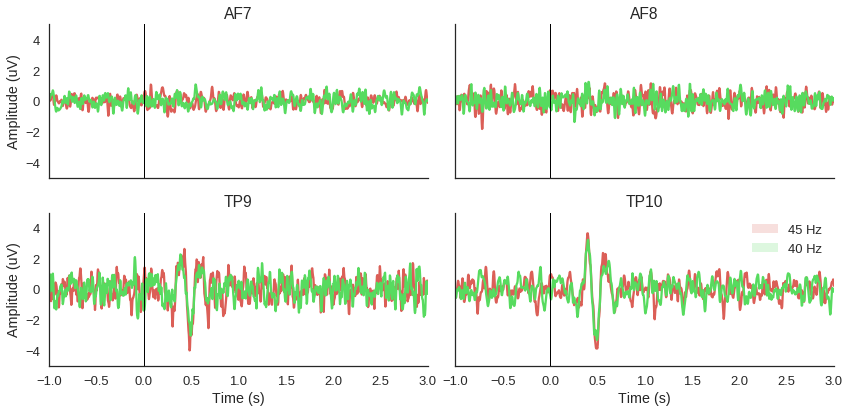

In [8]:
conditions = OrderedDict()
conditions[stim_freqs_str[0]] = [1]
conditions[stim_freqs_str[1]] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1, title='',
                                diff_waveform=None, ylim=(-5, 5))

The stimulation pattern is not easily visible in the temporal domain, probably due to phase variation in the stimulus presentation. However, the ERP created by the beginning of the stimulus generates a clear N1 - P2 complex in the temporo-parietal electrodes.

## Decoding

We use a filter bank approach on the original 4 Muse electrodes (to see how the headband alone without external electrodes could be used to classify SSVEP):

1. Apply bandpass filters around both stimulation frequencies
2. Concatenate bandpass-filtered channels
2. Extract epochs (from 1 to 3 s after stimulus onset, to avoid classifying the ERP)
3. Apply common classification pipelines

In [9]:
# Bandpass filter the raw data
raw_filt_40Hz = raw.copy().filter(37, 43, method='iir')
raw_filt_45Hz = raw.copy().filter(42, 48, method='iir')
raw_filt_40Hz.rename_channels(lambda x: x + '_40Hz')
raw_filt_45Hz.rename_channels(lambda x: x + '_45Hz')

# Concatenate with the bandpass filtered channels
raw_all = raw_filt_40Hz.add_channels([raw_filt_45Hz], 
                                     force_update_info=True)

# Extract epochs
events = find_events(raw_all)
event_id = {stim_freqs_str[0]: 1, stim_freqs_str[1]: 2}

epochs_all = Epochs(raw_all, events=events, event_id=event_id, tmin=1, 
                     tmax=3, baseline=None, reject={'eeg': 100e-6}, 
                     preload=True, verbose=False, add_eeg_ref=False)

Setting up band-pass filter from 37 - 43 Hz
Setting up band-pass filter from 42 - 48 Hz
197 events found
Events id: [1 2]


In [10]:
epochs_all.pick_types(eeg=True)
X = epochs_all.get_data() * 1e6
times = epochs.times
y = epochs_all.events[:, -1]

In [11]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict

clfs = OrderedDict()

clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

CSP + RegLDA
Cov + TS
Cov + MDM
CSP + Cov + TS


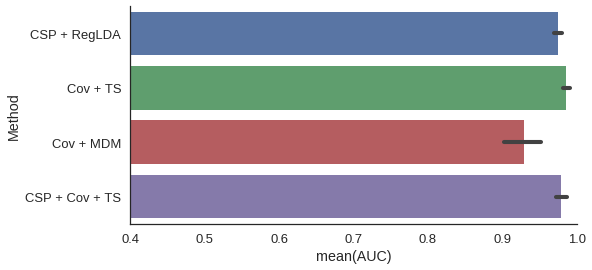

In [12]:
fig = plt.figure(figsize=[8, 4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 1)
sns.despine()